## Imports

In [19]:
import os
import cv2
import random
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
import matplotlib.image as mpimg
import PIL

from PIL import Image, ImageDraw, ImageFont
from ultralytics import YOLO

## Paths

In [20]:
images_path = "images"
labels_path = "labels"
annotated_images_path = "annotated_image_data"
predictions_yolo = "predictions_yolo"
validate = "validate"


## Exploratory Data Analysis

Visualizing branch points on a random image from dataset. Uses YOLO labels made from corresponding .xml file to annotate.

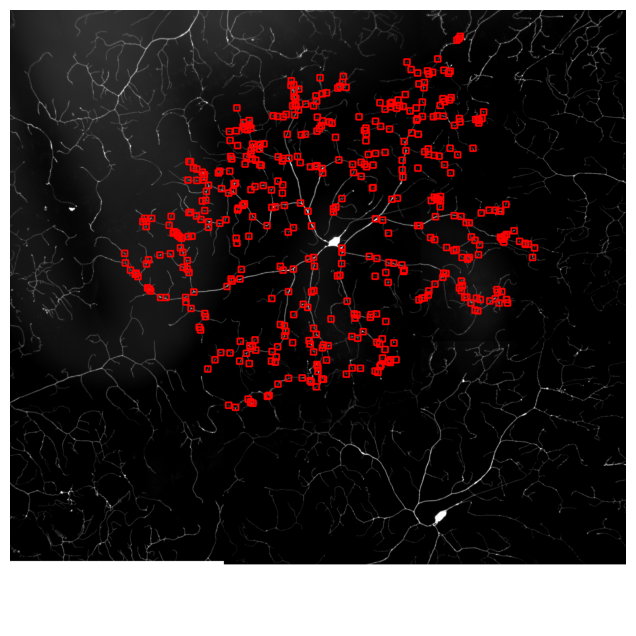

In [21]:
image_files = os.listdir(images_path)

random_image_file = random.choice(image_files)

# Set up the plot
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# Load the image
image_path = os.path.join(images_path, random_image_file)
image = cv2.imread(image_path)

# Load the labels for this image
label_file = os.path.splitext(random_image_file)[0] + ".txt"
label_path = os.path.join(labels_path, label_file)
with open(label_path, "r") as f:
    labels = f.read().strip().split("\n")

# Loop over the labels and plot the object detections
for label in labels:
    if len(label.split()) != 5:
        continue
    class_id, x_center, y_center, width, height = map(float, label.split())
    x_min = int((x_center - width/2) * image.shape[1])
    y_min = int((y_center - height/2) * image.shape[0])
    x_max = int((x_center + width/2) * image.shape[1])
    y_max = int((y_center + height/2) * image.shape[0])
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 0, 255), 3)

# Show the image with the object detections
axs.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs.axis('off')

plt.show()

Open the same image as saved in the annotated_image_data directory. Branch points are marked with tiny white points which make it easier to visualize the annotations recorded in .xml data.

Note: Raw dataset contained only images (image_data) and xml data (marker_xml_data). annotated_image_data (and other directories) was constructed to visualize the patterns of annotations provided in the xml data. All images seem to contain only annotations for branch points stemming from the central neuron and branch points found in the corners and edges of images were never annotated.

## A cleaner visualization

In [13]:
annotated_image_file = os.path.join(annotated_images_path, random_image_file)
path = annotated_image_file
  
  
# Reading an image in default mode
image = cv2.imread(path) 
  
# Window name in which image is displayed 
window_name = 'image'
  
# Using cv2.imshow() method 
# Displaying the image 
cv2.imshow(window_name, image) 
  
# waits for user to press any key 
# (this is necessary to avoid Python kernel from crashing) 
cv2.waitKey(0) 
  
# closing all open windows 
cv2.destroyAllWindows() 

## Model - YOLOv8

Making sure there is no overlap between training and test set:

In [22]:
images_files = os.listdir(images_path)
validate_files = os.listdir(validate)

images_set = set(images_files)
validate_set = set(validate_files)

common_files = images_set.intersection(validate_set)

print("Common file names in both directories:")
for file_name in common_files:
    print(file_name)

Common file names in both directories:


In [23]:
text = """
path: /Users/aryan/Desktop/branch_data
train: images
val: images

names:
  0: branch point
"""
with open("./data.yaml", 'w') as file:
    file.write(text)

In [24]:
model = YOLO('yolov8s.pt')

In [12]:
!pip -q install wandb
!wandb disabled

W&B disabled.


In [13]:
!yolo task=detect mode=train model=yolov8s.pt data="./data.yaml" epochs=300

New https://pypi.org/project/ultralytics/8.0.203 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.199 🚀 Python-3.10.10 torch-2.1.0 CPU (Apple M1 Pro)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=./data.yaml, epochs=300, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=N

Validation prediction image does not provide much information about the types of detections being made but does confirm the model is making detections.

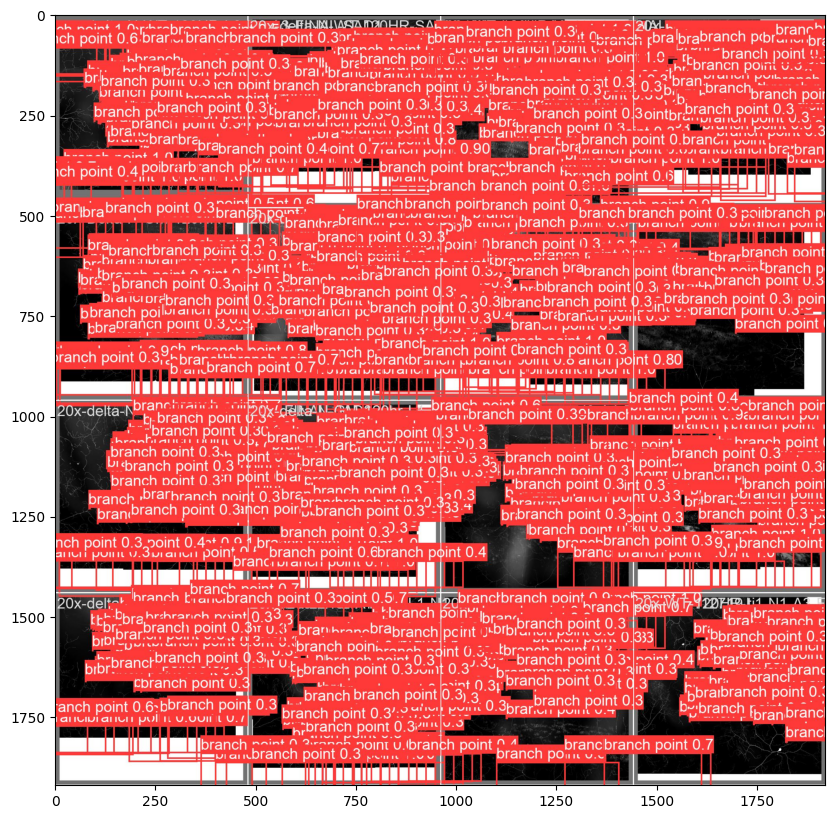

In [16]:
image_path = "runs/detect/train2/val_batch0_pred.jpg"
plt.figure(figsize=(20, 10))
img = Image.open(image_path)
plt.imshow(img)
plt.show()

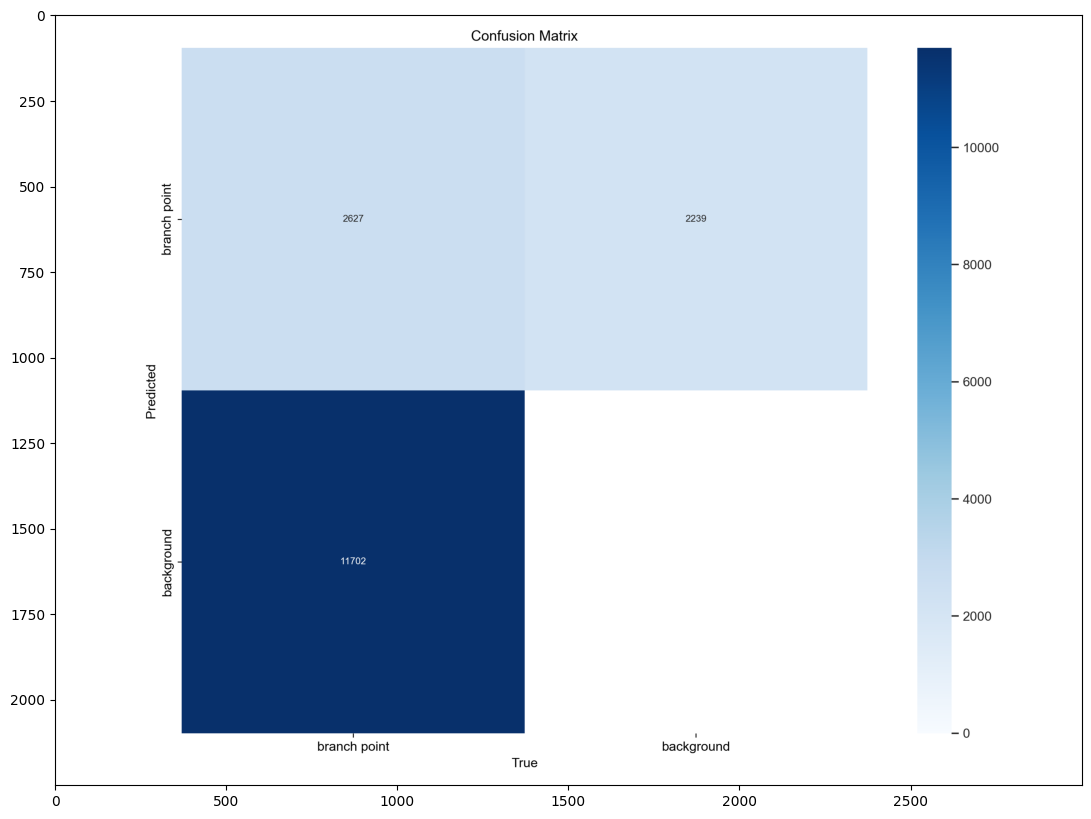

In [17]:
train_output_folder = "runs/detect/train2"

plt.figure(figsize=(20, 10))
img = Image.open(os.path.join(train_output_folder, 'confusion_matrix.png'))
plt.imshow(img)
plt.show()

## Validate

Model was validated on images that were not included in training due to not having a corresponding .xml file. Validation was rerun several times with different confidence values and model seems to have an upper limit of making 300 detections.

In [25]:
model = YOLO("runs/detect/train2/weights/best.pt")
results = model("validate", conf=0.10)


image 1/14 /Users/aryan/Desktop/branch_data/validate/20x-Delta-N-GM-120HR-L1-N1-A3-FINAL-SAD111919.tif: 640x640 300 branch points, 141.8ms
image 2/14 /Users/aryan/Desktop/branch_data/validate/20x-Delta-N-GM-120HR-L1-N1-A3-Q1-final-SAD113019.tif: 640x640 300 branch points, 106.5ms
image 3/14 /Users/aryan/Desktop/branch_data/validate/20x-Delta-N-GM-120HR-L1-N1-A3-final-SAD112319.tif: 640x640 300 branch points, 101.4ms
image 4/14 /Users/aryan/Desktop/branch_data/validate/20x-Delta-N-GM-120HR-L1-N2-A4-FINAL-SAD111919.tif: 640x640 300 branch points, 106.2ms
image 5/14 /Users/aryan/Desktop/branch_data/validate/20x-GM-120HR-L1-N1-A3-FINAL-SAD112419.tif: 640x640 300 branch points, 106.1ms
image 6/14 /Users/aryan/Desktop/branch_data/validate/20x-GM-120HR-L1-N1-A3-FINAL-SAD112519.tif: 640x640 247 branch points, 104.0ms
image 7/14 /Users/aryan/Desktop/branch_data/validate/20x-GM-120HR-L1-N2-A4-FINAL-SAD111919.tif: 640x640 300 branch points, 109.4ms
image 8/14 /Users/aryan/Desktop/branch_data/val

In [15]:
# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category

Ultralytics YOLOv8.0.199 🚀 Python-3.10.10 torch-2.1.0 CPU (Apple M1 Pro)
val: Scanning /Users/aryan/Desktop/branch_data/labels.cache... 28 images, 0 backgrounds, 0 corrupt: 100%|██████████| 28/28 [00:00<?, ?it/s]
train: WARNING ⚠️ /Users/aryan/Desktop/branch_data/images/20x-delta-N-GM-120hr-L1-N1-A3-FINAL-SAD020220.tif: 4 duplicate labels removed
train: WARNING ⚠️ /Users/aryan/Desktop/branch_data/images/20x-delta-N-GM-120hr-L1-N2-A4-Q4-FINAL-SAD020220.tif: 1 duplicate labels removed
train: WARNING ⚠️ /Users/aryan/Desktop/branch_data/images/20x-delta-N-WT-120hr-L2-N1-A3-FINAL-SAD020220.tif: 2 duplicate labels removed
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:07<00:07,  7.02s/it]WARNING ⚠️ NMS time limit 1.100s exceeded
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:20<00:00, 10.45s/it]
                   all         28      14329      0.408      0.

array([   0.092818])

Inferring model results on a single image from validation set using default confidence (0.25).

If image used for validation contains white parts, as seen in many images in dataset, model predicts huge bounding boxes near them.

In [31]:
# Define path to the image file. #1 in val set ran two cells above.
source = "/Users/aryan/Desktop/branch_data/validate/20x-Delta-N-GM-120HR-L1-N1-A3-Q1-final-SAD113019.tif"

# Run inference on the source
results = model(source)  # list of Results objects


image 1/1 /Users/aryan/Desktop/branch_data/validate/20x-Delta-N-GM-120HR-L1-N1-A3-Q1-final-SAD113019.tif: 640x640 263 branch points, 120.2ms
Speed: 3.9ms preprocess, 120.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


In [27]:
for r in results:
    im_array = r.plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    im.show()  # show image
    #im.save('results.jpg')  # save image

## A cleaner visualization - Predicting

Since we have a lot of branch point detections, YOLO provides a messy output plot and so we will convert it into something that is easier to look at.

The function will only run as intended if the model has already predicted on the input image (i.e. user ran predict.py script successfully on the input image) and will save the prediction to the predictions_yolo directory.

In [32]:
def annotate_prediction(image_path):
    """
    Given an image model has already predicted on,
    provides a cleaner visualization identical to images found in annotated_image_data directory.

    Params:
        image_path: absolute path to image that model has predicted on.

    Returns:
        None. Saves image to predictions_yolo directory.
    """
    # Define paths
    image_name = os.path.basename(image_path)
    label_name = os.path.splitext(image_name)[0] + ".txt"
    label_path = os.path.join(predictions_yolo, label_name)
    annotated_prediction = os.path.join(predictions_yolo, image_name)
    
    # Load the image
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    with open(label_path, 'r') as file:
        for line in file:
            line = line.strip().split(' ')
            class_id, x_center, y_center, width, height = map(float, line)

            # Convert YOLO coordinates to image coordinates
            image_width, image_height = image.size
            x = int(x_center * image_width)
            y = int(y_center * image_height)

            # Draw a marker on the image
            draw.ellipse([x - 2, y - 2, x + 2, y + 2], fill="white", outline="red")

    # Save the annotated image
    image.save(annotated_prediction)

In [30]:
# Example usage:
source = "/Users/aryan/Desktop/branch_data/validate/20x-Delta-N-GM-120HR-L1-N1-A3-Q1-final-SAD113019.tif"

annotate_prediction(source)

## Creating annotations for all images in Validation set

- Might have to generate xml format of predicted yolo labels. Write inverse function for function in convert.py

In [29]:
# for image in val set:
    # run predict.py on image to get output yolo label file
    # call annotate_prediction on image to get output predicted annotations
